In [1]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator

In [3]:
import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func

In [4]:
example_prop_frame = pandas.read_csv('prop_210216_4_individual_tile_1.csv')

loc = example_prop_frame[(example_prop_frame.x < 1500) & 
           (example_prop_frame.y < 1500) & 
           (example_prop_frame.z > 0) & 
           (example_prop_frame.z < 50)]

descriptors = ['label', 'cell_type', 'color']
n_colors = len(loc.cell_type.unique())

In [5]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [6]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

#legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
#loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

In [7]:
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(G, 'cell_type')

for node in G.nodes:
        
    nx.set_node_attributes(G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:cell_class[node]}, 'legend')

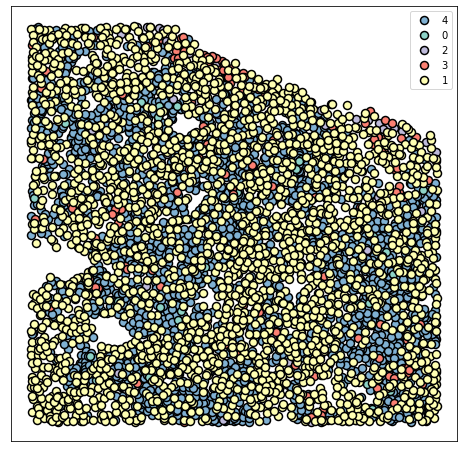

In [8]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [9]:
biograph = hmrf_estimator.hmrf(G, epochs = 5, gamma = 2)

In [10]:
biograph.initiate_latent_cell_type()

In [11]:
biograph.run()

100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


In [12]:
latent_G = biograph.graph

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(latent_G, 'latent_cell_type')

for node in latent_G.nodes:
        
    nx.set_node_attributes(latent_G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(latent_G, {node:cell_class[node]}, 'legend')

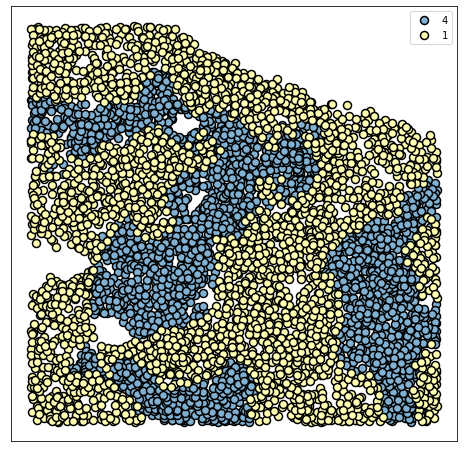

In [13]:
graphplot.scatter_plot_2D(latent_G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [14]:
biograph = probability_field_hmrf_estimator.hmrf(G, epochs = 30, gamma = 0.4, K = 6)

In [15]:
biograph.initiate_latent_probability_field()

100%|██████████| 5015/5015 [00:00<00:00, 26840.97it/s]


In [16]:
biograph.run()

100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


In [20]:
biograph.assign_cell_class(K = 4)

In [21]:
latent_G = biograph.graph

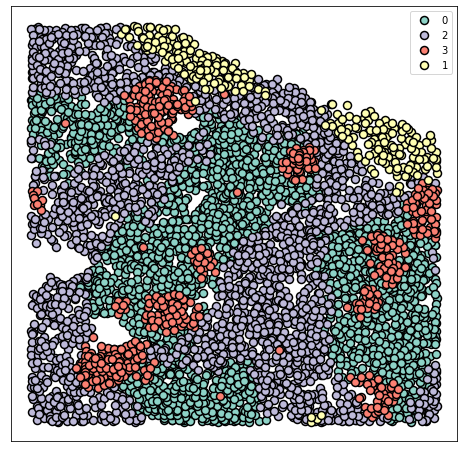

In [22]:
graphplot.scatter_plot_2D(latent_G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [94]:
def get_latent_probability_field_properties(G, number_of_cell_types):

    resultframe = pandas.DataFrame()
    i = 0
    
    latent_probability_field = nx.get_node_attributes(G, 'latent_probability_field')

    for node in sorted(G.nodes):
        
        resultframe.loc[i, 'label'] = node
        resultframe.loc[i, 'degree'] = len([n for n in G.neighbors(node)])
                
        for k in range(number_of_cell_types):
            resultframe.loc[i, k] = latent_probability_field[node][k]
            
        i += 1

    return resultframe.fillna(0)

def get_latent_probability_region_properties(latent_probability_field_properties):

    mean_props = pandas.DataFrame()
    i = 0

    for c in latent_probability_field_properties['class'].unique():

        mean_props.loc[i, 'class'] = c
        mean_props.loc[i, 'size'] = len(latent_probability_field_properties[latent_probability_field_properties['class'] == c])

        for column in latent_probability_field_properties.columns:

            mean_props.loc[i, column] = latent_probability_field_properties[latent_probability_field_properties['class'] == c][column].mean()

        i += 1
        
    return mean_props

In [95]:
latent_probability_field_properties = get_latent_probability_field_properties(biograph.graph, 
                                        biograph.number_of_cell_types)

In [109]:
latent_probability_field_properties.shape

(5015, 8)

In [96]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = latent_probability_field_properties[[0,1,2,3,4]].values.reshape(-1,5)
X = preprocessing.StandardScaler().fit_transform(X)

In [97]:
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

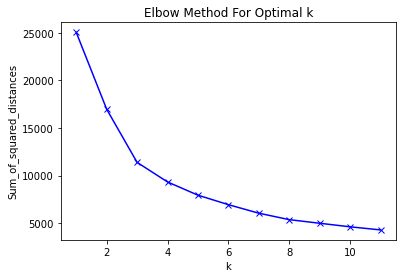

In [98]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [104]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

In [105]:
for ind in latent_probability_field_properties.index:
    
    latent_probability_field_properties.loc[ind, 'class'] = kmeans.labels_[ind]
    nx.set_node_attributes(latent_G, {ind:kmeans.labels_[ind]}, 'class')

In [106]:
get_latent_probability_region_properties(latent_probability_field_properties)

class    size        label     degree         0         1         2  \
0    2.0   477.0  2054.628931  11.815514  0.003601  0.667588  0.009015   
1    4.0  1962.0  2466.667686  12.804791  0.004719  0.512620  0.010117   
2    3.0   498.0  2676.100402  13.042169  0.020964  0.429828  0.008082   
3    0.0  1809.0  2642.047540  13.061360  0.007357  0.387460  0.003698   
4    1.0   269.0  2382.092937  11.851301  0.004665  0.577754  0.070671   

          3         4  
0  0.019410  0.300385  
1  0.026609  0.445934  
2  0.018674  0.522451  
3  0.018920  0.582566  
4  0.114446  0.232464

In [102]:
color_list = [plt.cm.Set3(i) for i in range(n_clusters)]

cell_class = nx.get_node_attributes(latent_G, 'class')

for node in G.nodes:
        
    nx.set_node_attributes(latent_G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(latent_G, {node:cell_class[node]}, 'legend')

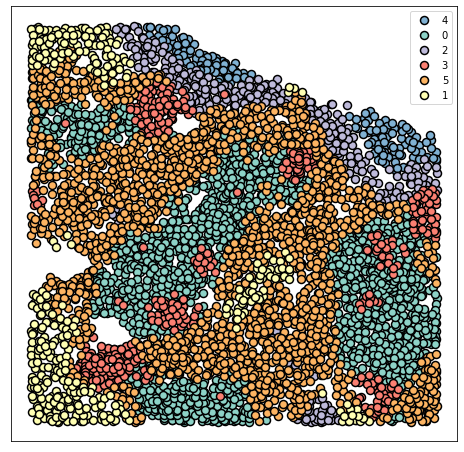